Работа нацелена на построение, обучение и сравнени генеративных моделей. В качестве датасета был выбран Fasion-MNIST:
- 70 000 черно-белых изображений (train: 60 000, test: 10 000)
- 28х28 пикселей
- 10 классов одежды

# Первая работа с генеративной моделью (VAE)

In [1]:
!pip install torchbearer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.4 MB/s eta 0:00:00


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Modeling

За основу возьмем [Beta-VAE](https://openreview.net/pdf?id=Sy2fzU9gl) модель. Текущая модель представляет из себя трехслойную CNN, похожую на Beta-VAE. Свертки 4*4 с небольшим заполнением помогают легко определять размеры выходных данных для каждого слоя

In [ ]:
import torchbearer
from torchbearer import state_key

MU = state_key('mu')
LOGVAR = state_key('logvar')

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_size: int):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            # (B — batch size, 1 канал, 28×28 пикселей)
            nn.Conv2d(1, 32, kernel_size=4, stride=1, padding=2),  # B, 32, 28, 28
            nn.ReLU(True),
            # Страйд 2 → уменьшаем пространственный размер в 2 раза
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1), # B, 32, 14, 14
            nn.ReLU(True),
            # Еще раз уменьшаем на 2
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # B, 64, 7, 7
        )

        self.mu = nn.Linear(64 * 7 * 7, latent_size)
        self.logvar = nn.Linear(64 * 7 * 7, latent_size)

        self.upsample = nn.Linear(latent_size, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 1, 2)
        )

    def reparameterize(self, mu, logvar):
        '''
        Добавляем к нему немного случайного шума.
        Сила шума определяется logvar: если сеть уверена — шума мало, если не уверена — шума больше.
        '''
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu


    def forward(self, x, state):
        image = x

        '''
        1. Кодируем изображение:
        - Сначала фильтры ищут простые вещи: края, пятна
        - Потом следующие — более сложные: формы, куски цифр
        - По пути картинка становится всё меньше по размеру с более сжатой информацией
        - Преобразуем полученное в один единый список чисел
        '''
        x = self.encoder(x).relu().view(x.size(0), -1)

        '''
        2. Вычисляем среднее - основной типичный вариант кода для этой картинки.
        '''
        mu = self.mu(x)

        '''
        3. Вычисляем разброс - насколько сильно этот код может колебаться.
        '''
        logvar = self.logvar(x)

        '''
        4. Учимся описывать облако похожих картинок - извлекаем латентный код
        '''
        sample = self.reparameterize(mu, logvar)


        '''
        5. Восстанавливаем изображение по латентному коду и декодируем его,
        увеличивая размер и дорисовывая детали. Постепенно сеть размазывает
        и уточняет признаки, чтобы получилась цельная картинка.
        '''
        result = self.decoder(self.upsample(sample).relu().view(-1, 64, 7, 7))

        '''
        6. Сохраняем состояние на каждом шаге для функции потерь при обучении
        '''
        if state is not None:
            state[torchbearer.Y_TRUE] = image
            state[MU] = mu
            state[LOGVAR] = logvar

        return result


Так, модель будет кодировать входное изображение в латентное пространство, выберет значения из этого пространства и декодирует их для полуения выходных данных. Она также положит все, что нужно в state.

## Before training

Теперь загрузим данные

In [3]:
import torch
from torchvision import transforms
from torchvision.datasets import FashionMNIST


transform = transforms.Compose([transforms.ToTensor()])

train = FashionMNIST(root='../', train=True, transform=transform, download=True)
test = FashionMNIST(root='../', train=False, transform=transform)

trainget = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=8)
testget = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False, num_workers=8)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.68MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 179kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.5MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


В качестве loss функции будем использовать KL-дивергенцию.

KL-дивергенция — это мера того, насколько два распределения вероятностей отличаются друг от друга

```
Total Loss = Reconstruction Loss + β × KL Divergence

Reconstruction Loss (BCE/MSE): насколько восстановленная картинка похожа на оригинал

KL Divergence: насколько распределение кодов q(z|x) (от энкодера) похоже на стандартное N(0,1)
```

Пусть есть два мешка с шариками:
**Истинный мешок P** (реальность): 90% красных, 10% синих
**Предсказанный мешок Q** (модель): 70% красных, 30% синих

KL-дивергенция отвечает на вопрос:
> Если я буду вытаскивать шарики из мешка Q, но думать, что вероятности как в P — сколько я потеряю информации?


Будем использовать именно ее потому, что:
```
P(z) = N(0, 1)  ← стандартное нормальное
Q(z|x) = N(μ, σ) ← то, что выучил энкодер для картинки x
```
Q(z|x) должен быть похож на N(0,1) для каждой картинки x. Если все коды z лежат около (0,0) в нормальном облаке — можно генерировать новые картинки, просто семплируя из N(0,1). Латентное пространство становится гладким и непрерывным:

```
KL(N(μ,σ) || N(0,1)) = ½ × Σ [μ² + σ² - 1 - log(σ²)]

KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta

logvar = log(σ²) — логарифм дисперсии
mu.pow(2) — насколько далеко центр от нуля
logvar.exp() — насколько большая дисперсия (σ²)
1 + logvar — нормализация для стандартного нормального
beta — умножаем на вес β (по умолчанию 5 для β-VAE)
```

Реализуем лосс через декоратор для torchbearer

In [ ]:
import torchbearer.callbacks as callbacks

def beta_kl(mu_key, logvar_key, beta=5):
    # Вызываем декоратор на каждом этапе обучения после forward И добавляем к общему лоссу
    # Неявно: total_loss = base_loss + callback(state)
    @callbacks.add_to_loss
    def callback(state):
        mu = state[mu_key]
        logvar = state[logvar_key]
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta
    return callback

Удобно будет также визуализировать некоторые этапы треннировочного процесса. У torchbearer есть функционал и для этого

In [ ]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
%matplotlib inline

def plot_progress(key=torchbearer.Y_PRED, num_images=100, nrow=10):
    @callbacks.on_step_validation
    @callbacks.once_per_epoch
    def callback(state):
        images = state[key]
        image = make_grid(
            images[:num_images], nrow=nrow, normalize=True
        )[0, :, :]

        plt.imshow(image.detach().cpu().numpy(), cmap='gray')
        plt.show()

    return callback


## Trainig

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


0/20(t): loss=7111.5718, mse=0.0584, running_loss=6093.7803, running_mse=0.0453
1/20(t): loss=5907.752, mse=0.0424, running_loss=5769.2744, running_mse=0.0407
2/20(t): loss=5733.1104, mse=0.0398, running_loss=5694.9438, running_mse=0.039
3/20(t): loss=5659.0034, mse=0.0387, running_loss=5619.0273, running_mse=0.0383
4/20(t): loss=5611.2661, mse=0.038, running_loss=5676.0474, running_mse=0.0383
5/20(t): loss=5573.9111, mse=0.0375, running_loss=5558.0894, running_mse=0.0373
6/20(t): loss=5543.1724, mse=0.0371, running_loss=5572.0791, running_mse=0.0372
7/20(t): loss=5525.2725, mse=0.0368, running_loss=5488.0801, running_mse=0.0364
8/20(t): loss=5511.5981, mse=0.0365, running_loss=5529.4761, running_mse=0.0366
9/20(t): loss=5489.5078, mse=0.0363, running_loss=5479.6367, running_mse=0.0361
10/20(t): loss=5474.1807, mse=0.0361, running_loss=5444.1787, running_mse=0.0358
11/20(t): loss=5475.7217, mse=0.0359, running_loss=5467.4106, running_mse=0.0357
12/20(t): loss=5463.7461, mse=0.0358, run

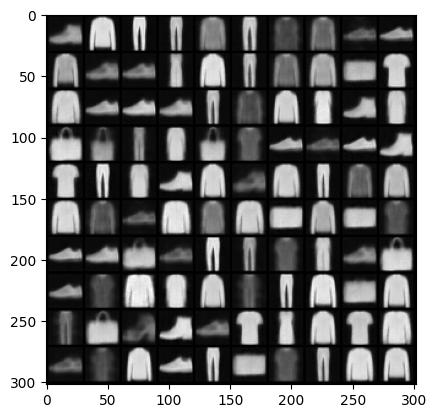

0/1(v): test_loss=4510.6763, test_mse=0.0265


{'test_mse': 0.0264980960637331, 'test_loss': 4510.67626953125}

In [ ]:
import torch.optim as optim
from torchbearer import Trial

model = VAE(latent_size=10)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)

trial = Trial(model, optimizer, nn.MSELoss(reduction='sum'), metrics=['acc', 'loss'], callbacks=[
    beta_kl(MU, LOGVAR),
    callbacks.ConsolePrinter(),
    plot_progress()
], verbose=1).with_generators(train_generator=trainget, test_generator=testget)

trial.to('cuda')
trial.run(20)
trial.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)

In [ ]:
torch.save({
    'model_stat_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'latent_size': 10,
    'input_size': 784 #(28×28),
}, 'vae_trained_model.pth')

## Images generation

In [ ]:
model.eval().to('cuda')

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (mu): Linear(in_features=3136, out_features=10, bias=True)
  (logvar): Linear(in_features=3136, out_features=10, bias=True)
  (upsample): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
)

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def generate_64_pics():
    # Generate 64 new normalizing images from latent space
    with torch.no_grad():
        z = torch.randn(64, 10).to('cuda')  # 8x8 = 64
        generated = model.decoder(model.upsample(z).relu().view(-1, 64, 7, 7)).cpu()
        generated = torch.sigmoid(generated)

    # Generate grid
    grid_img = make_grid(generated, nrow=8, padding=2, normalize=True)

    # Show imgs
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray') # CHW -> HWC
    plt.axis('off')
    plt.title('VAE 8*8 generated images')
    plt.show()

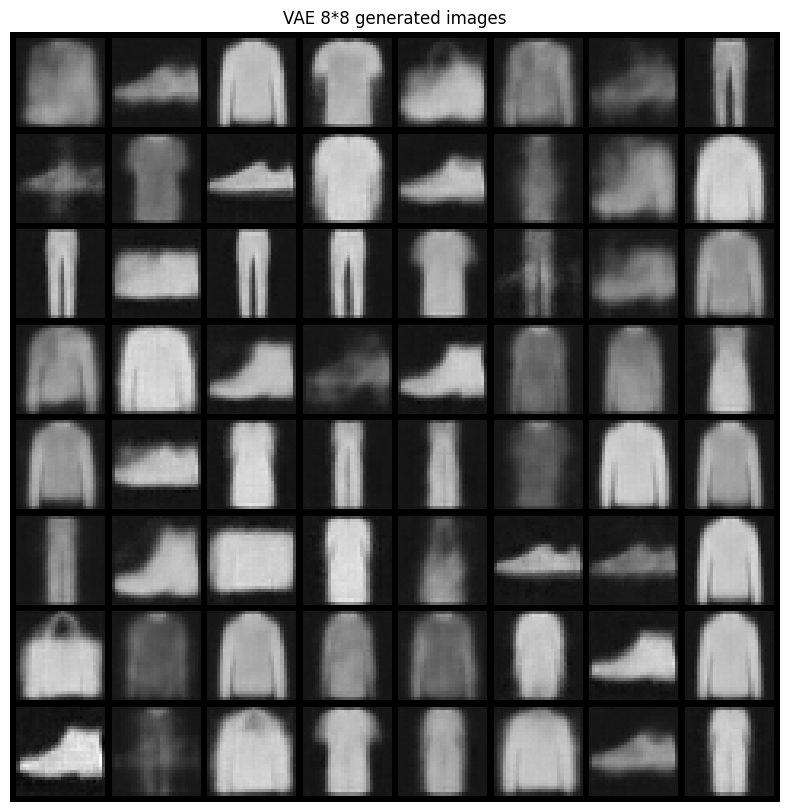

In [ ]:
generate_64_pics()

## Interpolation

Полученное *латентное пространство* - это сжатая копия всех Fasion MNIST изображений в виде векторов (точек) в `latent_size=10` мерном пространстве.

Интерполяция - переход между двумя точками А и В
`(Тапок -> Тапок+Сумка -> Полусумка -> Сумка)`


**Цель:** Показать, что обученный VAE научился делать плавные переходы между сущностями латентного пространства

In [ ]:
# Define usefull functions

def get_latent_codes(img):
    '''Из картинки → латентный вектор (mu)'''
    model.eval()

    with torch.no_grad():
        encoded = model.encoder(img.to('cuda')).view(img.size(0), -1)
        mu = model.mu(encoded)

    return mu.cpu()

def interpolate(z_a, z_b, steps=8):
    '''z_a → ... → z_b (8 шагов)'''
    alphas = torch.linspace(0, 1, steps)
    z_interp = (1-alphas[:,None]) * z_a + alphas[:,None] * z_b
    return z_interp

def decode_seq(z_seq):
    '''[8,10] → 8 картинок [8,1,28,28]'''
    model.eval()
    z_seq_gpu = z_seq.to('cuda')

    with torch.no_grad():
        upsampled = model.upsample(z_seq_gpu).relu()  # [8, 3136] cuda
        upsampled = upsampled.view(-1, 64, 7, 7)      # [8, 64, 7, 7] cuda
        decoded = model.decoder(upsampled)             # [8, 1, 28, 28] cuda

    return torch.sigmoid(decoded).cpu()            # [8, 1, 28, 28] CPU

In [ ]:
test = next(iter(testget))
images = test[0]

images.shape

torch.Size([128, 1, 28, 28])

In [ ]:
# Get 3 pairs of random images

rand_ind = torch.randperm(images.size(0))[:6]
target_images = images[rand_ind]

pairs = [
    (target_images[0:1], target_images[1:2]),
    (target_images[2:3], target_images[3:4]),
    (target_images[4:5], target_images[5:6])
]


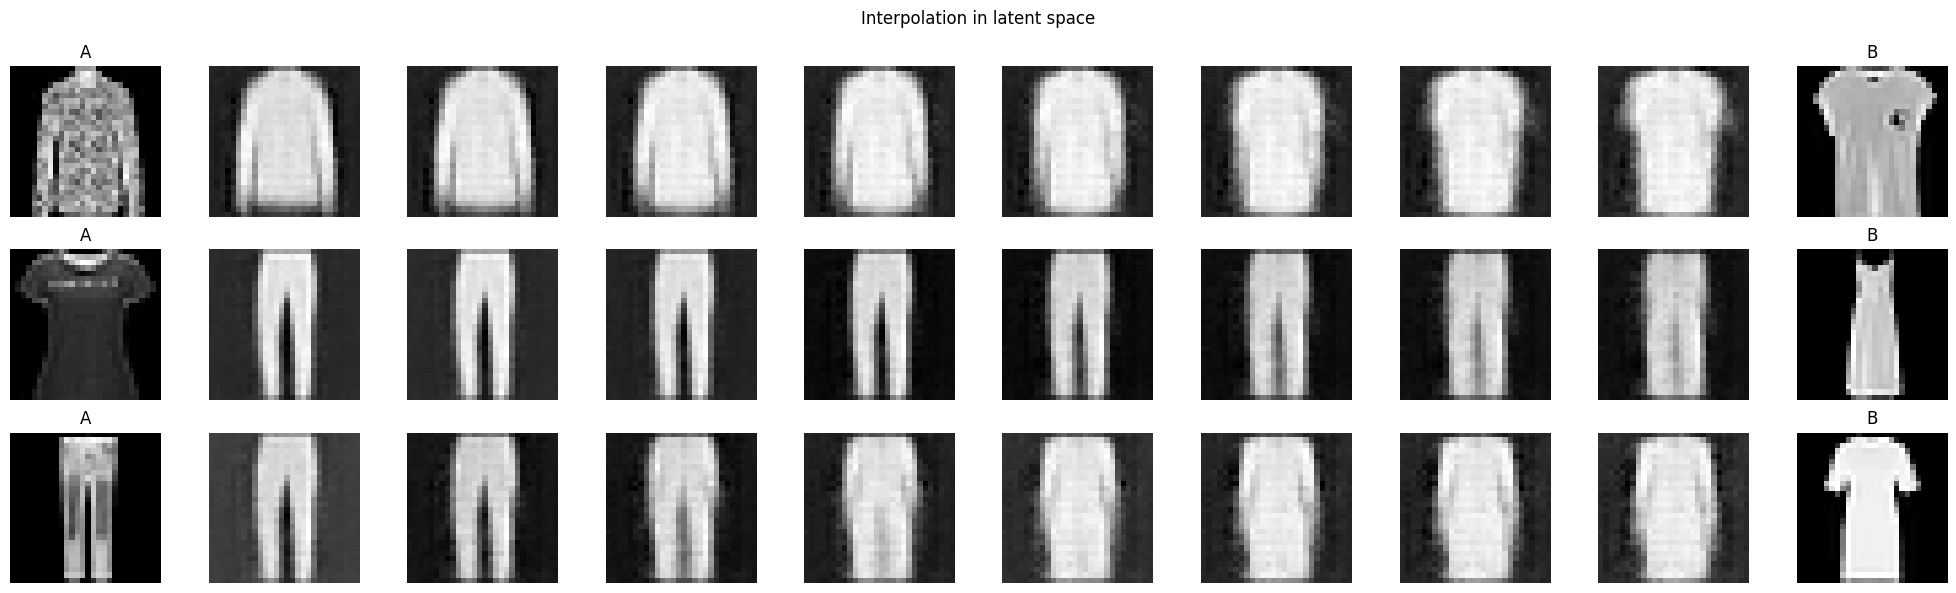

In [ ]:
# Show images

fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i, (img_a, img_b) in enumerate(pairs):
    # Get latent codes
    z_a = get_latent_codes(img_a)
    z_b = get_latent_codes(img_b)

    # Interpolation
    z_interp = interpolate(z_a, z_b)

    # Decode
    img_interp = decode_seq(z_interp)

    # Show: a + 8 interpolations + b
    axes[i, 0].imshow(img_a.squeeze(), cmap='gray')
    axes[i, 0].set_title('A')
    axes[i, 0].axis('off')

    for j in range(8):
        axes[i, j+1].imshow(img_interp[j].squeeze(), cmap='gray')
        axes[i, j+1].axis('off')

    axes[i, -1].imshow(img_b.squeeze(), cmap='gray')
    axes[i, -1].set_title('B')
    axes[i, -1].axis('off')

plt.suptitle('Interpolation in latent space')
plt.tight_layout()
plt.show()


**Результаты**
1. Насколько осмысленными выглядят сгенерированные изображения:
    - Изображения осмысленные и узнаваемые по метрике (MSE=0.0265) и визуально
    - Присутствует типичное размытие, но семантика одежды сохраняется

2. Оценка интерполяции:
    - Переходы плавные и предсказуемые в большинстве случаев
    - Резких скачков и шума не наблюдается

3. Общие выводы:
    - Латентное пространство организовано семантически: единый класс кластеризуется близко
    - Выбранных 10 измерений достаточно для захвате ключевых признаков одежды
    - Результат при базовой VAE на 20 эпохах очень хороший
    - Интерполяция дает постепенную эволюцию формы
    - Интерполяция эффективна, а пути выглядят реалистично

# Диффузионная модель (DDPM)

**DDPM** — это генеративная модель, которая создаёт изображения, постепенно убирая шум из случайного шума. В отличие от VAE, DDPM работает через 1000 мелких шагов, превращая шус в изображение.

**Core conv UNet**

Роль симметричного сверточного UNet-а заключается в определении шума или сигнала для каждого пикселя и предсказании шума в той же размерности


## Modeling

Ранее на курсе Нейронные сети я реализовывала [UNet архитектуру](https://github.com/0LinaSt0/pass_hometasks/blob/main/cv_nn/lab5_unet_segmentation.ipynb). Воспользуемся ей в качестве conv базы.

Однако необходимо проапгрейдить архитектуру: добавить поддержку time conditionin, поменять выход финального слоя на выход шума, увеличить количество каналов и пр.

In [83]:
import torchbearer
from torchbearer import state_key

NOISE_PRED = state_key('noise_pred')

In [64]:
import torch
import torch.nn as nn
import math

# Sinusoidal positional embedding для t
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        return emb


class UNet(nn.Module):
    def __init__(self, time_dim=128):
        super().__init__()

        self.time_mlp = nn.Sequential(
            TimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        self.conv1 = self.double_conv2d(1, 32, 3)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = self.double_conv2d(32, 64, 3)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = self.double_conv2d(64, 128, 3)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv4 = self.double_conv2d(128 + 64, 64, 3)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv5 = self.double_conv2d(64 + 32, 32, 3)

        self.final = nn.Conv2d(32, 1, kernel_size=1)

        self.time_to_c3 = nn.Linear(time_dim, 128)

    def double_conv2d(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        t_c3 = self.time_to_c3(t_emb)[:, :, None, None]

        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        c3 = c3 + t_c3

        up1 = self.up1(c3)
        merge1 = torch.cat([c2, up1], dim=1)
        c4 = self.conv4(merge1)

        up2 = self.up2(c4)
        merge2 = torch.cat([c1, up2], dim=1)
        c5 = self.conv5(merge2)

        return self.final(c5)

## Before training

**При Forward Duffusion:**
```
x_t = √(1-β_t) × x_{t-1} + √β_t × ε, где ε ~ N(0,1)

β_t — маленькая доля шума на шаге t (0.0001 → 0.02)
```
К изображению добавляется шум 0.1% итеративно 1000 раз -> x₁₀₀₀ ~ N(0,1). За 1000 шагов картинка полностью разрушается до гауссова шума

**При Reverse Duffusion:**

Происходит обучение модели: на шаге `t` из `x_t` модель предсказывает шум `ε`, который был добавлен, и убират его. Это происходит итеративно 1000 раз. На финальном шаге получаем предсказанныйы конечный шум.

In [84]:
class DDPM(nn.Module):
    def __init__(self, model, timesteps=1000, device='cuda'):
        super().__init__()
        self.model = model
        self.device = device
        self.timesteps = timesteps

        self.betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    def forward(self, x):
        B = x.size(0)
        t = torch.randint(0, self.timesteps, (B,), device=self.device)

        noise = torch.randn_like(x)
        alpha_hat_t = self.alpha_hat[t][:, None, None, None]

        x_t = torch.sqrt(alpha_hat_t) * x + torch.sqrt(1 - alpha_hat_t) * noise
        noise_pred = self.model(x_t, t.float())

        return noise_pred, noise

    @torch.no_grad()
    def sample(self, n):
        x = torch.randn(n, 1, 28, 28).to(self.device)

        for t in reversed(range(self.timesteps)):
            t_batch = torch.full((n,), t, device=self.device).float()
            noise_pred = self.model(x, t_batch)

            alpha = self.alphas[t]
            alpha_hat = self.alpha_hat[t]
            beta = self.betas[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (1 / torch.sqrt(alpha)) * (
                x - (1 - alpha) / torch.sqrt(1 - alpha_hat) * noise_pred
            ) + torch.sqrt(beta) * noise

        return x

class Wrapper(nn.Module):
    def __init__(self, ddpm):
        super().__init__()
        self.ddpm = ddpm

    def forward(self, x, state):
        noise_pred, noise = self.ddpm(x)

        if state is not None:
            state[torchbearer.Y_TRUE] = noise
            state[NOISE_PRED] = noise_pred

        return noise

`MSE(ε_real, ε_predicted)`

In [85]:
import torchbearer
import torchbearer.callbacks as callbacks

def ddpm_loss():
    @callbacks.add_to_loss
    def callback(state):
        return nn.functional.mse_loss(
            state[NOISE_PRED],
            state[torchbearer.Y_TRUE]
        )
    return callback

Также реализуем визуализацию

In [86]:
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
%matplotlib inline

def plot_diffusion_samples(model, num_images=100, nrow=10):
    @callbacks.on_step_validation
    @callbacks.once_per_epoch
    def callback(state):
        samples = model.sample(num_images)
        grid = make_grid(samples, nrow=nrow, normalize=True)[0]
        plt.imshow(grid.detach().cpu(), cmap='gray')
        plt.show()
    return callback

## Training

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128)

  0%|          | 0/20 [00:00<?, ?it/s]

0/20(t): 468/469 
0/20(v): 0/79 

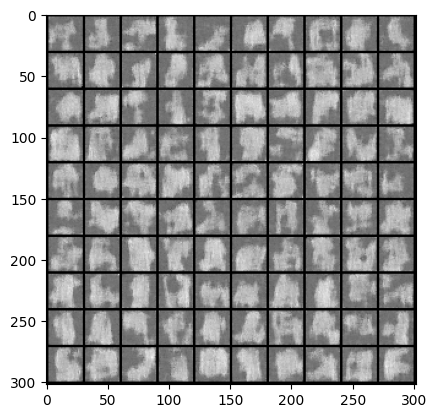

0/20(v): 78/79 
1/20(t): 468/469 
1/20(v): 0/79 

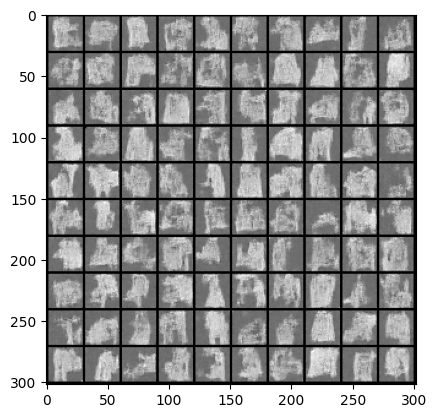

1/20(v): 78/79 
2/20(t): 468/469 
2/20(v): 0/79 

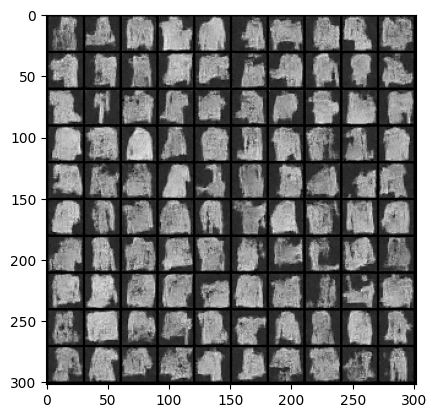

2/20(v): 78/79 
3/20(t): 468/469 
3/20(v): 0/79 

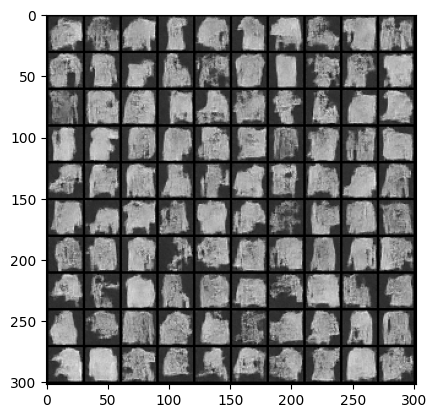

3/20(v): 78/79 
4/20(t): 468/469 
4/20(v): 0/79 

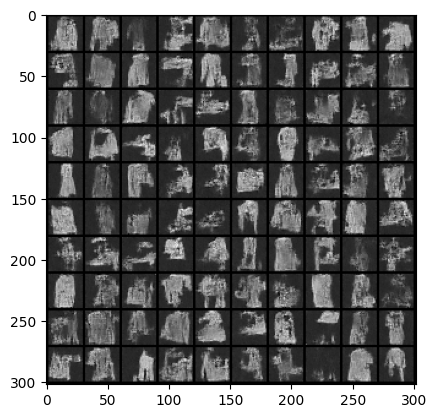

4/20(v): 78/79 
5/20(t): 468/469 
5/20(v): 0/79 

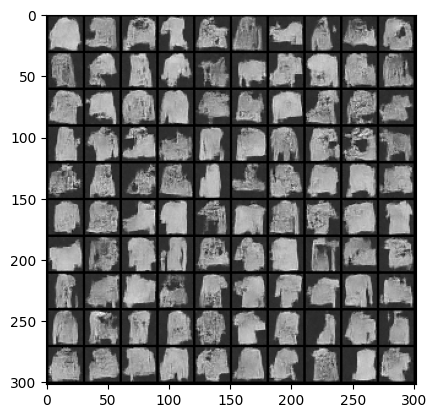

5/20(v): 78/79 
6/20(t): 468/469 
6/20(v): 0/79 

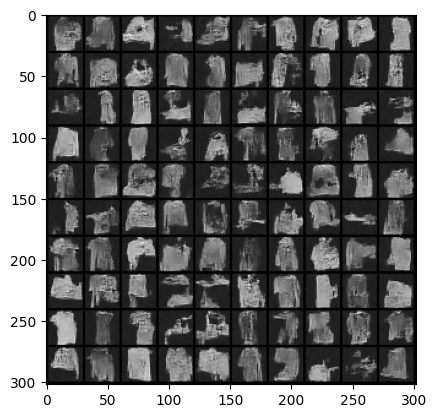

6/20(v): 78/79 
7/20(t): 468/469 
7/20(v): 0/79 

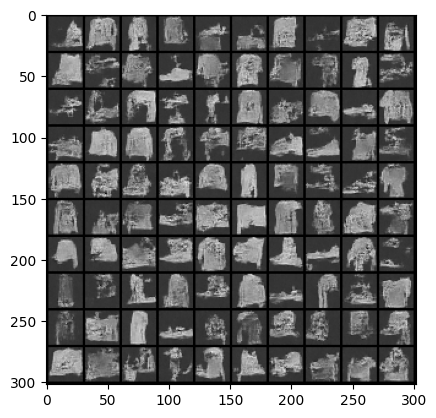

7/20(v): 78/79 
8/20(t): 468/469 
8/20(v): 0/79 

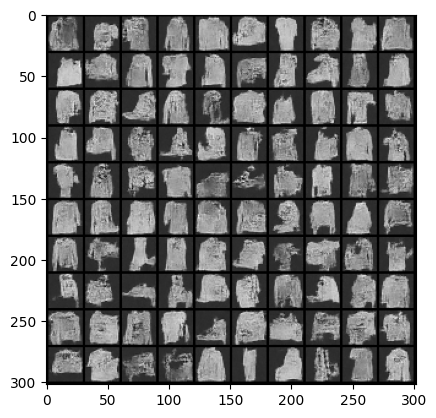

8/20(v): 78/79 
9/20(t): 468/469 
9/20(v): 0/79 

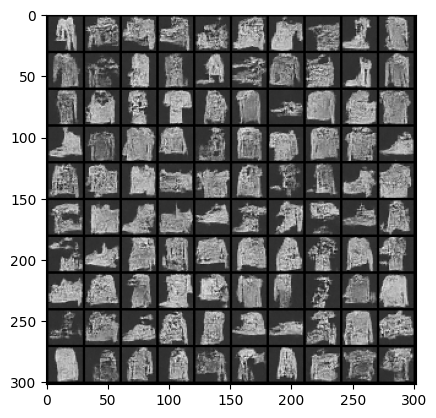

9/20(v): 78/79 
10/20(t): 468/469 
10/20(v): 0/79 

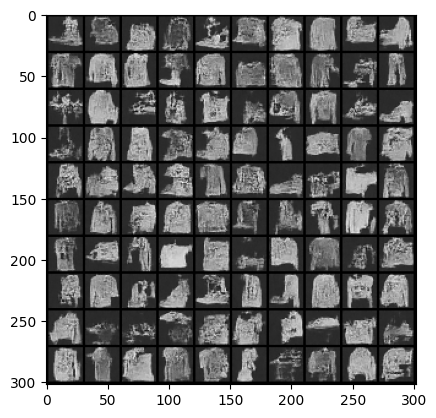

10/20(v): 78/79 
11/20(t): 468/469 
11/20(v): 0/79 

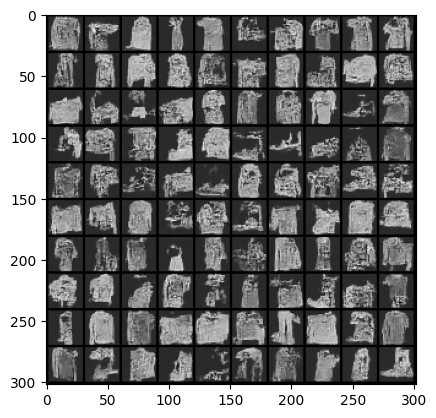

11/20(v): 78/79 
12/20(t): 468/469 
12/20(v): 0/79 

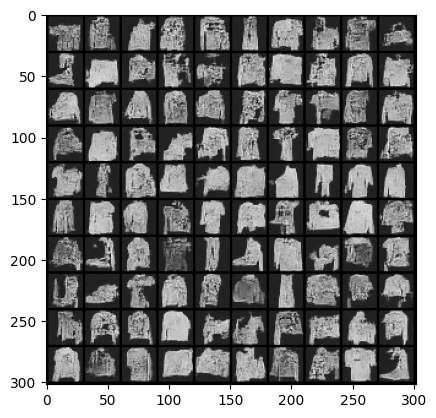

12/20(v): 78/79 
13/20(t): 468/469 
13/20(v): 0/79 

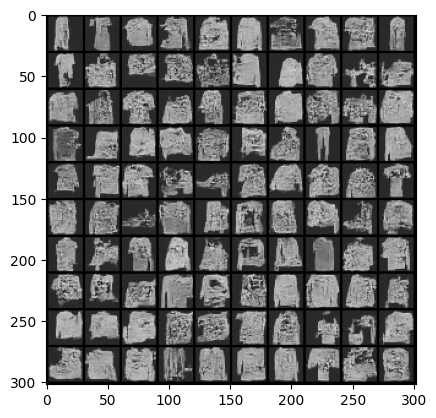

13/20(v): 78/79 
14/20(t): 468/469 
14/20(v): 0/79 

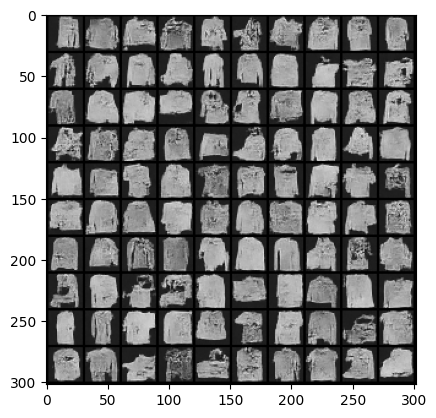

14/20(v): 78/79 
15/20(t): 468/469 
15/20(v): 0/79 

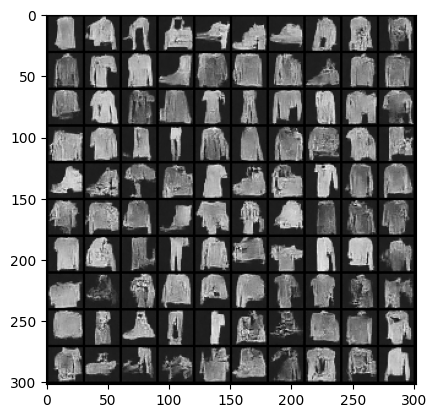

15/20(v): 78/79 
16/20(t): 468/469 
16/20(v): 0/79 

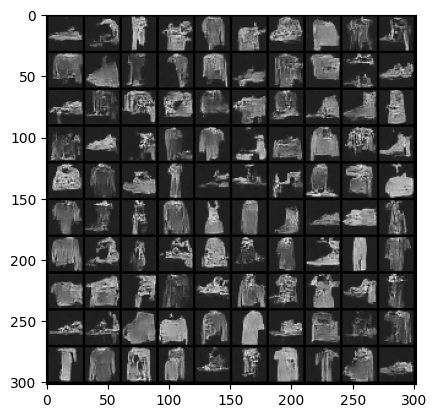

16/20(v): 78/79 
17/20(t): 468/469 
17/20(v): 0/79 

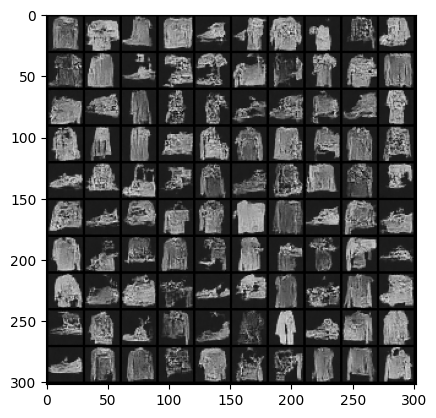

17/20(v): 78/79 
18/20(t): 468/469 
18/20(v): 0/79 

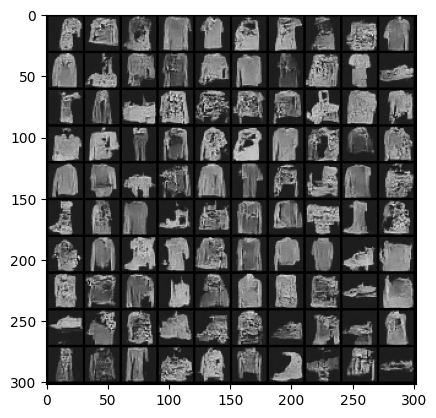

18/20(v): 78/79 
19/20(t): 468/469 
19/20(v): 0/79 

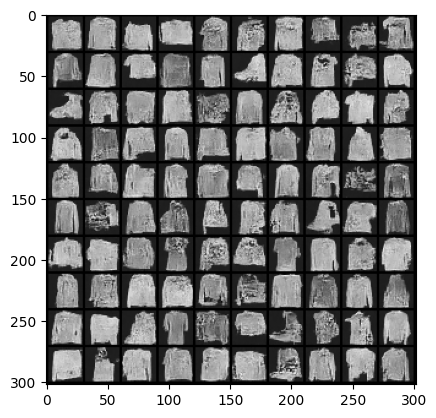

19/20(v): 78/79 


[{'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79},
 {'train_steps': 469, 'validation_steps': 79}]

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torchbearer import Trial

device = 'cuda'

unet = UNet()
ddpm = DDPM(unet, timesteps=300, device=device)

optimizer = optim.Adam(ddpm.parameters(), lr=2e-4)
model = Wrapper(ddpm)

trial = Trial(
    model,
    optimizer,
    criterion=lambda x, y: torch.tensor(0., device=device),
    callbacks=[
        ddpm_loss(),
        callbacks.ConsolePrinter(),
        plot_diffusion_samples(ddpm)
    ], verbose=1
).with_generators(trainloader, testloader)

trial.to(device)
trial.run(20)

In [92]:
torch.save(ddpm.state_dict(), 'ddpm_unet.pth')

## Images generation

In [95]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def generate_64_pics():
    # Generate 64 new normalizing images from latent space
    with torch.no_grad():
        generated = ddpm.sample(64).cpu()

    # Generate grid
    grid_img = make_grid(generated, nrow=8, padding=2, normalize=True)

    # Show imgs
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray') # CHW -> HWC
    plt.axis('off')
    plt.title('DDPM 8*8 generated images')
    plt.show()

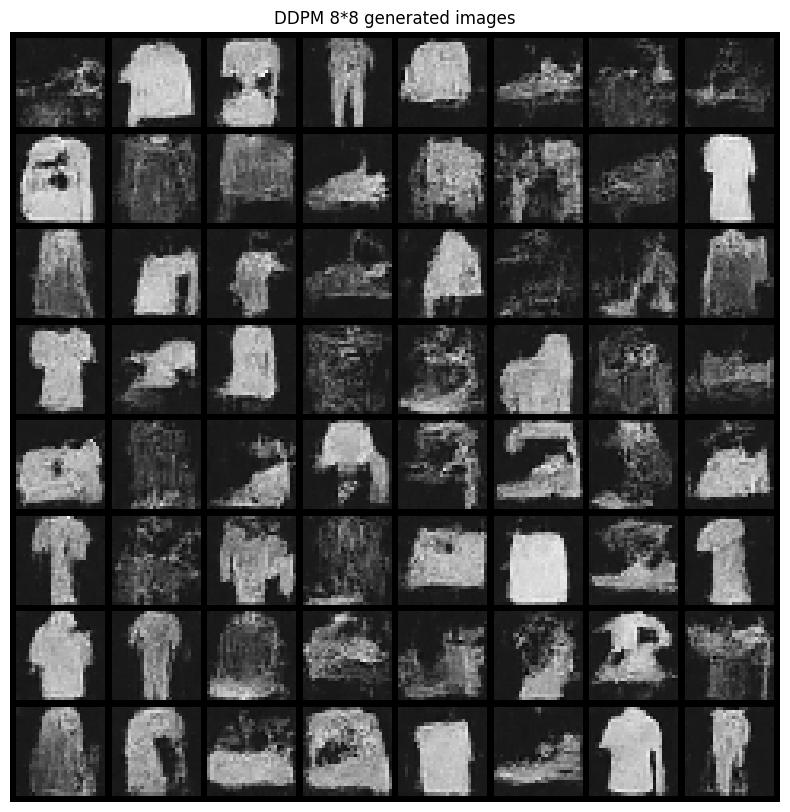

In [ ]:
ddpm.eval().to('cuda')
generate_64_pics()

# Сравнение архитектур

## Easy classifier

Обучим простой классификатор на Fasion MNIST для оценки генераторов

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class FMnistClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

In [ ]:
from tqdm import tqdm

device = 'cuda'

model = FMnistClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in tqdm(range(5)):
    total_loss = 0

    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
    
        optimizer.step()
    
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(trainloader):.4f}')

 20%|██        | 1/5 [00:12<00:48, 12.02s/it]

Epoch 1, Loss: 0.5819


 40%|████      | 2/5 [00:24<00:36, 12.02s/it]

Epoch 2, Loss: 0.3840


 60%|██████    | 3/5 [00:36<00:24, 12.03s/it]

Epoch 3, Loss: 0.3338


 80%|████████  | 4/5 [00:48<00:12, 12.04s/it]

Epoch 4, Loss: 0.3007


100%|██████████| 5/5 [01:00<00:00, 12.02s/it]

Epoch 5, Loss: 0.2772


In [ ]:
torch.save(model.state_dict(), 'fmnist_classifier.pth')

## Load models

In [ ]:
classifier = FMnistClassifier().eval()
classifier.load_state_dict(torch.load('fmnist_classifier.pth'))

<All keys matched successfully>

In [ ]:
vae = VAE(latent_size=10).eval()
checkpoints = torch.load('/kaggle/input/models/msalena/vae/pytorch/default/1/vae_trained_model.pth', map_location='cpu')
# checkpoints = torch.load('vae_trained_model.pth', map_location='cpu')

vae.load_state_dict(checkpoints['model_stat_dict'])

<All keys matched successfully>

In [ ]:
unet = UNet().to(device)
ddpm = DDPM(unet, device=device).eval()

ddpm.load_state_dict(torch.load('ddpm_unet.pth', map_location=device))

<All keys matched successfully>

## Generate samples

Сгенерируем 150 примеров каждым из генераторов и оценим метрики на этих сэмплах

In [ ]:
import time

def generate_imgs(m_vae, m_ddpm, c_img=150):
    m_vae.eval().to('cuda')
    m_ddpm.eval().to('cuda')

    with torch.no_grad():
        start = time.perf_counter()
        z = torch.randn(c_img, 10).to('cuda')
        generated = m_vae.decoder(m_vae.upsample(z).relu().view(-1, 64, 7, 7)).cpu()
        vae_imgs = torch.sigmoid(generated)

        print(
            f"VAE generation for {c_img} completed in "
            f"{(time.perf_counter() - start):.3f} seconds"
        )

        start = time.perf_counter()
        ddpm_imgs = m_ddpm.sample(c_img).cpu()
        print(
            f"DDPM generation for {c_img} completed in "
            f"{(time.perf_counter() - start):.3f} seconds"
        )

    return vae_imgs, ddpm_imgs

In [ ]:
vae_imgs, ddpm_imgs = generate_imgs(vae, ddpm)


vae_imgs.shape, ddpm_imgs.shape

VAE generation for 150 completed in 0.004 seconds
DDPM generation for 150 completed in 18.118 seconds


(torch.Size([150, 1, 28, 28]), torch.Size([150, 1, 28, 28]))

## Compare results

Оценим качество сгенерированных изображений через уверенность предобученного классификатора:
1. Предскажем класс для каждого изображения (максимальная вероятность)
2. Оценим долю изображений с уверенностью по трэшхолду в 80%
3. Определим среднюю уверенность по всем изображениям

In [ ]:
def evaluate_confidence(imgs, classifier, threshold=0.8, device=device):
    imgs = imgs.to(device)
    classifier.to(device)

    with torch.no_grad():
        logits = classifier(imgs)
        probs = F.softmax(logits, dim=1)
        max_probs = probs.max(dim=1)[0].cpu().numpy()
    
    hight_conf_share = (max_probs > threshold).mean()
    avg_conf = max_probs.mean()

    return hight_conf_share, avg_conf, max_probs

In [ ]:
vae_share, vae_avg, vae_max_probs = evaluate_confidence(vae_imgs, classifier)

ddpm_share, ddpm_avg, ddpm_max_probs = evaluate_confidence(ddpm_imgs, classifier)

In [ ]:
vae_share, vae_avg

(np.float64(0.0), np.float32(0.3681741))

In [ ]:
ddpm_share, ddpm_avg

(np.float64(0.31333333333333335), np.float32(0.6361566))

Оценим уверенности по бинам визуально

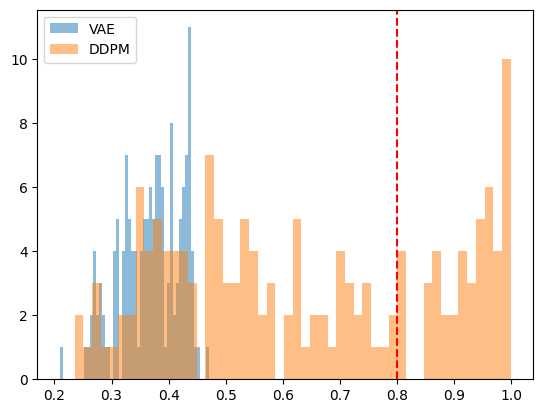

In [ ]:
import matplotlib.pyplot as plt
plt.hist(vae_max_probs, bins=50, alpha=0.5, label='VAE')
plt.hist(ddpm_max_probs, bins=50, alpha=0.5, label='DDPM')
plt.axvline(0.8, color='r', ls='--')
plt.legend()
plt.show()


Представим сравнительную таблицу 

| Характеристика     | VAE                | DDPM                |
| ------------------ | ------------------ | ------------------- |
| Latent space       | Фиксирован (10D)   | Каждый шаг меняется |
| Шаги генерации     | 1 forward          | 1000 forward        |
| Визуальное качество           | Визуально лучше, но объективно проигрывает из-за отсутствия четкости краев | Визуально присутствую артефакты, но объективно лучше с четкими контурами   |
| Метрика(avg_prob) | 0.37 | 0.64 |
| Скорость train     | Быстро             | Медленно            |
| Скорость генерации | 0.041/150 (sec/count)          | 18.126/150 (sec/count)           |

Таким образом, оценка сгенерированных двумя моделями 150 изображений показала, что несмотря на кажущуюся визуальную выгодность VAE модели, DDPM значительно превосходит VAE по метрикам:
- DDPM генерирует изображения с чёткими контурами, что более важно для CNN
- VAE даёт размытые образцы из-за потерь при реконструкции — классификатор колебается между классами

Однако DDPM архитектура обучается значительно медленнее и, что более критично, по скорости генерации уступаем VAE в ~400 раз.

Можно заключить, что метод генерации необходимо подбирать исходя из поставленной задачи 